# Distributed FWI with Devito using Tensorflow and Dask

## Inversion Computational Setup

### Accessing Google Cloud Storage

In [1]:
import cloudpickle as pickle
from google.cloud import storage

saved_true_model_file = "true_model"
saved_smooth_model_file = "smooth_model"
saved_shot_data_file_prefix = "shot"
bucket_name = "fwi-data"


def create_bucket(bucket_name=bucket_name):
    """Creates a new bucket."""
    storage_client = storage.Client()
    bucket = storage_client.lookup_bucket(bucket_name)
    if not bucket: 
        bucket = storage_client.create_bucket(bucket_name)
    print('Bucket {} created'.format(bucket.name))
    
def delete_bucket(bucket_name=bucket_name):
    """Deletes a bucket. The bucket must be empty."""
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    if bucket: 
        bucket.delete()
    print('Bucket {} deleted'.format(bucket.name))

def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket."""
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name)

    print('File {} uploaded to {}.'.format(
        source_file_name,
        destination_blob_name))
    
def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(source_blob_name)

    blob.download_to_filename(destination_file_name)

    print('Blob {} downloaded to {}.'.format(
        source_blob_name,
        destination_file_name))

def dump_model(model, file_name):
    pickle.dump(model, open(file_name, 'wb'))


def get_model(file_name):
    return pickle.load(open(file_name, "rb"))
        

def dump_shot_data(file_name, shot_id, src, true_data):
    pickle.dump({'src': src, 'rec': true_data}, open(file_name, 'wb'))


def get_shot_data(file_name, shot_id, dt):
    shot_data = pickle.load(open(file_name, 'rb'))
    shot_data['src'] = shot_data['src'].resample(dt)
    shot_data['rec'] = shot_data['rec'].resample(dt)
    return shot_data


def upload_model_to_gcloud(model, model_file):
    dump_model(model, model_file)
    upload_blob(bucket_name, model_file, model_file)

    
def download_model_from_gcloud(model_file):
    download_blob(bucket_name, model_file, model_file)
    return get_model(model_file)


def upload_shot_to_gcloud(shot_id, src, true_data):
    file_name = '{}_{}'.format(saved_shot_data_file_prefix, shot_id)
    dump_shot_data(file_name, shot_id, src, true_data)
    upload_blob(bucket_name, file_name, file_name)

    
def download_shot_from_gcloud(shot_id, dt):
    file_name = '{}_{}'.format(saved_shot_data_file_prefix, shot_id)
    download_blob(bucket_name, file_name, file_name)
    return get_shot_data(file_name, shot_id, dt)

create_bucket()

Bucket fwi-data created


### Setting up (synthetic) data

In [2]:
from examples.seismic import TimeAxis, RickerSource, Receiver
from examples.seismic.acoustic import AcousticWaveSolver

def generate_shot_data(t0, tn, f0, shots, receivers, client):
    params = [t0, tn, f0, shots, receivers]
    work = [params + [shot_id] for shot_id in range(shots)]

    fgi = [client.submit(generate_shot_data_i, *job) for job in work]

    wait(fgi)


def generate_shot_data_i(t0, tn, f0, shots, receivers, shot_id):
    true_model = download_model_from_gcloud(saved_true_model_file)

    # Time step from model grid spacing
    dt = true_model.critical_dt

    # Acquisitional Geometry
    time_range = TimeAxis(start=t0, stop=tn, step=dt)
    src = RickerSource(name="src", grid=true_model.grid, f0=f0,
                       time_range=time_range)
    
    src.coordinates.data[0, :] = [30, shot_id*1000./(shots-1)]
    
    rec = Receiver(name="rec", grid=true_model.grid, time_range=time_range,
                   npoint=receivers)
    rec.coordinates.data[:, 1] = np.linspace(0, true_model.domain_size[0],
                                             num=receivers)
    rec.coordinates.data[:, 0] = 980.  # 20m from the right end

    # set up solver
    solver = AcousticWaveSolver(true_model, src, rec, space_order=4)

    # generate synthetic receiver data from true model
    true_data, _, _ = solver.forward(src=src, m=true_model.m)
    
    upload_shot_to_gcloud(shot_id, src, true_data)  

### Computational Consideration

In [3]:
shape = (101, 101)
spacing = (10., 10.)
origin = (0., 0.)

shots = 9
receivers = 101
epochs = 5

t0 = 0.
tn = 1000.
f0 = 0.01

### True and Smooth Models

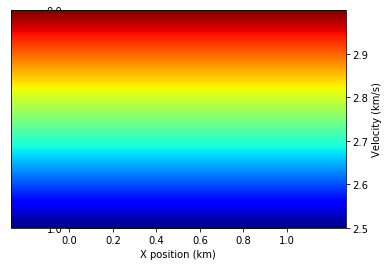

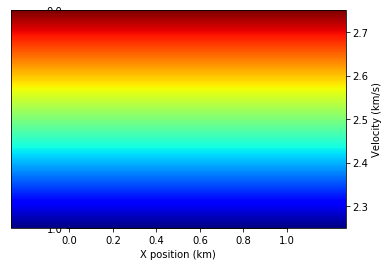

In [4]:
from examples.seismic import demo_model, plot_velocity
from devito import configuration
from distributed import Client, LocalCluster, wait

configuration['log_level'] = 'WARNING'

true_model = demo_model('circle-isotropic', vp=3.0, vp_background=2.5,
                        origin=origin, shape=shape, spacing=spacing, nbpml=40)

smooth_model = demo_model('circle-isotropic', vp=2.5, vp_background=2.5,
                          origin=origin, shape=shape, spacing=spacing, nbpml=40)

plot_velocity(true_model)
plot_velocity(smooth_model)

## Dask Specifics

In [5]:
class fg_pair:
    def __init__(self, f, g):
        self.f = f
        self.g = g

    def __add__(self, other):
        f = self.f + other.f
        g = self.g + other.g
        return fg_pair(f, g)

    def __radd__(self, other):
        if other == 0:
            return self
        else:
            return self.__add__(other)

## Dask-Kubernetes Specifics

In [6]:
from socket import gethostname, gethostbyname

def get_scheduler_info(scheduler_port=30000):
    scheduler_ip = gethostbyname(gethostname())
    scheduler_addr = str(scheduler_ip) + ":" + str(scheduler_port)
    return [scheduler_addr, scheduler_port]

## Operators for gradient based inversion

In [7]:
from devito import Function

def fwi_gradient_i(shot_id):
    from devito import clear_cache
    
    clear_cache()

    smooth_model = download_model_from_gcloud(saved_smooth_model_file)

    params = download_shot_from_gcloud(shot_id, smooth_model.critical_dt)
    src = params['src']
    rec = params['rec']
    
    solver = AcousticWaveSolver(smooth_model, src, rec, space_order=4)

    smooth_data, u0, _ = solver.forward(src=src, m=smooth_model.m, save=True)

    residual = Receiver(name='rec', grid=smooth_model.grid,
                        time_range=rec.time_range,
                        coordinates=rec.coordinates.data)

    residual.data[:] = smooth_data.data[:] - rec.data[:]

    f = .5*np.linalg.norm(residual.data.flatten())**2

    grad = Function(name="grad", grid=smooth_model.grid)
    solver.gradient(rec=residual, u=u0, m=smooth_model.m, grad=grad)

    g = np.array(grad.data[:])

    return fg_pair(f, g)

In [8]:
def fwi_gradient(client, smooth_model, shots):
    upload_model_to_gcloud(smooth_model, saved_smooth_model_file)

    # Distribute job to workers - equivalent to the use of client.map(..)
    fgi = [client.submit(fwi_gradient_i, shot_id) for shot_id in range(shots)]

    # Distribute worklist to workers
    total = client.submit(sum, fgi)
    fg = total.result()

    return fg.f, fg.g

## FWI with Tensorflow

In [9]:
import tensorflow as tf
import numpy as np
import functools as ft
from dask.distributed import Client, LocalCluster, wait
from dask_kubernetes import KubeCluster, make_pod_spec
from examples.seismic import plot_velocity, plot_perturbation

class TF_Devito_Fwi:

    def __init__(self, nshots, nreceivers, true_model, smooth_model, t0, tn, f0,
                 optimizer_func, hparams, scheduler_addr, scheduler_port, workers=1):
        # True and Smooth velocity models
        upload_model_to_gcloud(true_model, saved_true_model_file)
        self.smooth_model = smooth_model
        true_data = true_model.m.data
        
        # Cluster setup
        cluster = KubeCluster.from_yaml('config/worker.yaml',
                                        port=scheduler_port,
                                        env={'DASK_SCHEDULER_ADDRESS': scheduler_addr})       
        cluster.scale(workers)
        client = Client(cluster)
        self.client = client
        
        # Generating shot data and uploading to gcloud
        generate_shot_data(t0, tn, f0, nshots, nreceivers, client)

        # Create the tf graph
        self.sess = tf.Session() # Session 
        
        with tf.name_scope("Input"):
            self.smooth_data = tf.Variable(self.smooth_model.m.data)
            tf.summary.histogram('smooth_model', self.smooth_data)
        
        fwi_gradient_call = ft.partial(fwi_gradient, client, smooth_model, nshots)
        with tf.name_scope("Gradient_and_Functional"):
            f, g = tf.py_func(fwi_gradient_call, [], [tf.float64, tf.float32])
            tf.summary.scalar("functional", f)
        
        with tf.name_scope("SGD"):
            if 'learning_rate' in list(hparams.keys()):
                alpha = hparams['learning_rate']
            else: 
                alpha = 0.005 / tf.reduce_max(g)
            optimizer = optimizer_func(alpha, **hparams)
            self.train_op = optimizer.apply_gradients([(g, self.smooth_data)])
        
        with tf.name_scope("Relative_Error"):
            self.relative_error = tf.norm((self.smooth_data-true_data)/true_data)
            tf.summary.scalar("relative_error", self.relative_error)
        
        self.sess.run(tf.global_variables_initializer())
        self.merged_summary_op = tf.summary.merge_all()
    
    def train(self, epochs):
        summary_writer = tf.summary.FileWriter('./logs/', self.sess.graph)
        
        for i in range(0, epochs):
            _, re, summary = self.sess.run([self.train_op, self.relative_error, self.merged_summary_op])
            summary_writer.add_summary(summary, i)
            yield re
            
        self.smooth_model.m.data[:] = self.smooth_data.eval(session=self.sess)

### Initialise Dask Distributed Scheduler for FWI

In [10]:
optimizer = tf.train.MomentumOptimizer

hparam = {'momentum': 0.4, 'use_nesterov': True}

scheduler_addr, scheduler_port = get_scheduler_info()

fwi = TF_Devito_Fwi(shots, receivers, true_model, smooth_model, t0, tn, f0,
                    optimizer, hparam, scheduler_addr, scheduler_port, shots)

fwi.client

File true_model uploaded to true_model.


Client Scheduler: tcp://10.8.2.22:30000 Dashboard: http://10.8.2.22:8787/status,Cluster Workers: 9 Cores: 9 Memory: 18.00 GB


### Dask Statistics Visualisation

In [14]:
%%bash
kubectl get svc | grep svc-notebooks | awk '{printf $4 ":8787/status"}' | \
xargs -I ip echo "<iframe src='http://ip' height="800" width="100%"></iframe>" > dask_iframe
cat dask_iframe

<iframe src='http://35.192.115.88:8787/status' height=800 width=100%></iframe>


In [15]:
from IPython.core.display import display, HTML
display(HTML(filename="dask_iframe"))

### Running Tensorflow Graph

In [16]:
relative_losses = np.zeros((epochs, 1))

for i, rl in enumerate(fwi.train(epochs)):
    print("Epoch: {}, Relative Losses: {}".format(i, rl))
    relative_losses[i] = rl

File smooth_model uploaded to smooth_model.
Epoch: 0, Relative Losses: 11.77359390258789
File smooth_model uploaded to smooth_model.
Epoch: 1, Relative Losses: 10.579763412475586
File smooth_model uploaded to smooth_model.
Epoch: 2, Relative Losses: 9.427884101867676
File smooth_model uploaded to smooth_model.
Epoch: 3, Relative Losses: 8.507863998413086
File smooth_model uploaded to smooth_model.
Epoch: 4, Relative Losses: 7.965253829956055


### Final Model

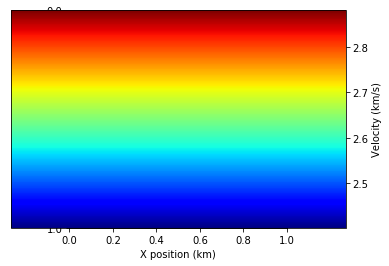

In [17]:
nbpml = true_model.nbpml
fwi.smooth_model.vp = np.sqrt(1. / smooth_model.m.data[nbpml:-nbpml, nbpml:-nbpml])

plot_velocity(fwi.smooth_model)

### Convergence of Losses

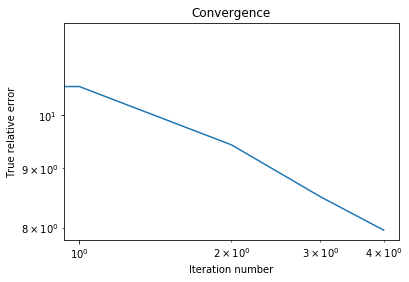

In [18]:
#NBVAL_SKIP
import matplotlib.pyplot as plt

# Plot objective function decrease
plt.figure()
plt.loglog(relative_losses)
plt.xlabel('Iteration number')
plt.ylabel('True relative error')
plt.title('Convergence')
plt.show()

### Tensorboard

In [4]:
%%bash
[[ -z "$(ls logs)" ]] && echo "Execute the graph above" || echo "logs dir present" 

logs dir present


Run the cell and then stop it running by pressing the stop button in the toolbar above. 

In [13]:
%%bash
tensorboard --logdir=./logs --port=8889 # This will fail if it has already been run once.

W1012 21:53:12.124647 Reloader tf_logging.py:120] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W1012 21:53:12.124647 140288466212608 tf_logging.py:120] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W1012 21:53:12.126203 Reloader tf_logging.py:120] Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
W1012 21:53:12.126203 140288466212608 tf_logging.py:120] Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
W1012 21:53:12.148683 Reloader tf_logging.py:120] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W1012 21:53:12.148683 1402884

CalledProcessError: Command 'b'tensorboard --logdir=./logs --port=8889\n'' returned non-zero exit status 255.

In [7]:
%%bash
kubectl get svc | grep svc-notebooks | awk '{printf $4 ":8889"}' | \
xargs -I ip echo "<iframe src='http://ip' height="500" width="100%"></iframe>" > tensorboard_iframe
cat tensorboard_iframe

<iframe src='http://35.192.115.88:8889' height=500 width=100%></iframe>


In [14]:
from IPython.core.display import display, HTML
display(HTML(filename="tensorboard_iframe"))